In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [1914]:
x = np.random.normal(1., 0.5, 100)
y = np.random.normal(0.5, 0.5, 100)
A = np.asarray([x,y])

x = np.random.normal(-1., 0.5, 100)
y = np.random.normal(0., 0.5, 100)
B = np.asarray([x,y])

x = np.empty(100)
x[:50] = np.random.normal(-1., 0.2, 50)
x[50:] = np.random.normal(1., 0.2, 50)
y = np.random.normal(0.3, 0.2, 100)
A = np.asarray([x,y])

x = np.random.normal(0., 0.3, 100)
y = np.random.normal(-0.1, 0.3, 100)
B = np.asarray([x,y])

In [1979]:
patterns = np.append(A, B, axis=1)
targets = np.append(np.ones(A.shape[1]), np.ones(B.shape[1]) * -1)

In [1980]:
permutation = np.random.permutation(len(targets))
targets = targets[permutation]
patterns = patterns[:,permutation]

In [1981]:
insize, ndata = patterns.shape
outsize = targets.shape

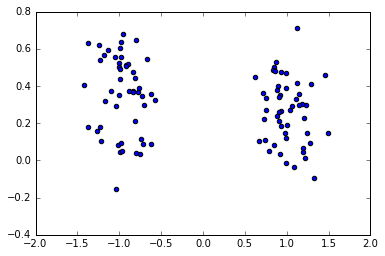

In [1982]:
ones = np.where(targets == 1)
plt.scatter(patterns[0,ones], patterns[1,ones])

In [1983]:
def delta(X, W, targets, eta=0.001):
    return -eta * (W.dot(X) - targets).dot(X.T)

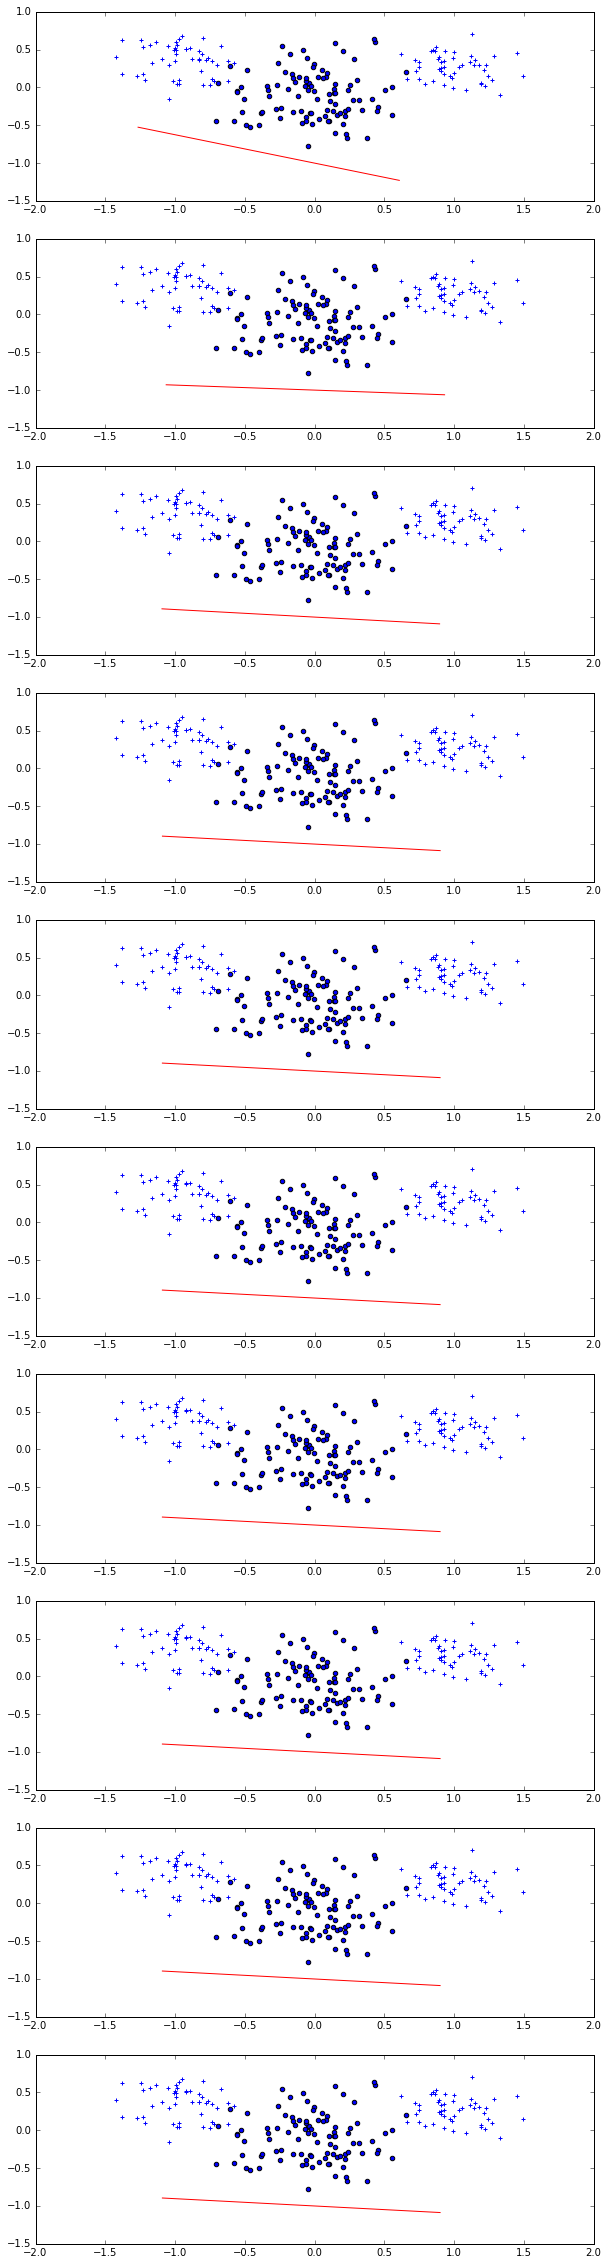

In [1984]:
W = np.zeros((1, len(patterns)))
W = get_random_weights(W.shape)

fig, axarr = plt.subplots(10,1, figsize=(10,40))
for i in range(10):
    W = delta(patterns, W, targets)
    p = W[0,:2]
    k = -W[0, insize - 1] / p.dot(p.T)
    l = np.sqrt(p.dot(p.T))
    pred = np.where(targets == 1)
    axarr[i].scatter(patterns[0,pred], patterns[1,pred], marker='+')
    pred = np.where(targets == -1)
    axarr[i].scatter(patterns[0,pred], patterns[1,pred], marker='o')
    x = np.array([p[0], p[0]]).dot(k) + [-p[1], p[1]]/l
    y = np.array([p[1], p[1]]).dot(k) + [p[0], -p[0]]/l
    axarr[i].plot(x, y, color='r')

In [1985]:
class MLP(object):
    
    def get_random_weights(shape):
        return np.random.uniform(low=-0.01, high=0.01, size=shape)   
    
    def __init__(self, X, T, layer_sizes):
        self.T = T
        self.layer_sizes = layer_sizes
        nr_data = X.shape[1]
        self.X = self.append_bias(X)
        nr_inputs = self.X.shape[0]
        nr_outputs = 1 if T.ndim == 1 else T.shape[0]
        print 'nr outputs: %s' % nr_outputs

        W = []
        w = get_random_weights((layer_sizes[0], nr_inputs))
        W.append(w)
        for layer in range(len(layer_sizes) - 1):
            shape = (layer_sizes[layer + 1], layer_sizes[layer])
            w = get_random_weights(shape)
            W.append(w)
        w = get_random_weights((nr_outputs, layer_sizes[-1]))
        W.append(w)
        self.W = W
        
    def append_bias(self, X):
        return np.append(X, np.ones((1, X.shape[1])), axis=0)
        
    def phi(self, X):
        return 2. / (1 + np.exp(-X)) - 1
    
    def phi_gradient(self, X):
        return ((1 + self.phi(X)) * (1 - self.phi(X))) / 2.
        
    def forwards(self, X):
        nr_data = X.shape[1]
        layers = [X]
        for layer in range(len(self.W)):
            lin = self.W[layer].dot(layers[layer])
#             layers.append(np.append(self.phi(lin), np.ones((1, nr_data)), axis=0))
            layers.append(self.phi(lin))
        return layers
    
    def backwards(self, layers):
        deltas = [(layers[-1] - self.T) * self.phi_gradient(layers[-1])]
        
        for layer in xrange(len(self.W) - 1, 0, -1):
            delta = self.W[layer].T.dot(deltas[-1]) * self.phi_gradient(layers[layer])
            if layer == 0:
                delta = delta[:len(self.W) - 1, :]
            deltas.append(delta)
        deltas.reverse()
        return deltas
    
    def update_weights(self, dW, layers, deltas, eta, alpha):
        for layer in range(len(self.W)):
            dW[layer] = (dW[layer] * alpha) - (deltas[layer].dot(layers[layer].T)) * (1-alpha);
            self.W[layer] += dW[layer] * eta;
    
    def train(self, max_iterations=1000, eta=0.04, alpha=0.9):
        dW = [np.zeros(w.shape) for w in self.W]
        for i in range(max_iterations):
            layers = mlp.forwards(self.X)
            deltas = mlp.backwards(layers)
            mlp.update_weights(dW, layers, deltas, eta, alpha)
            e = np.sum(np.sum(np.abs(np.sign(layers[-1]) - self.T)/2))
        print 'e: %s' % str(e/len(self.T))

    def predict(self, X, apply_sign=False):
        X_bias = self.append_bias(X)
        out = mlp.forwards(X_bias)[-1]
        return np.sign(out) if apply_sign else out

In [1986]:
mlp = MLP(patterns, targets, layer_sizes=[3])
mlp.train()

nr outputs: 1
e: 0.02


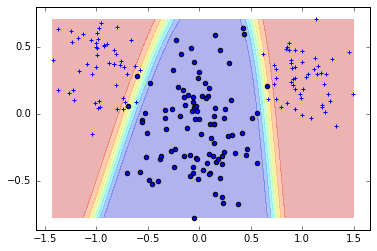

In [1987]:
x_min, x_max = patterns[0, :].min(), patterns[0, :].max()
y_min, y_max = patterns[1, :].min(), patterns[1, :].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

X_space = np.c_[xx.ravel(), yy.ravel()].T
Z = mlp.predict(X_space)

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3)

pred = np.where(targets == 1)
plt.scatter(patterns[0,pred], patterns[1,pred], marker='+')
pred = np.where(targets == -1)
plt.scatter(patterns[0,pred], patterns[1,pred], marker='o')

# Encoding problem

In [1988]:
encoding_patterns = np.eye(8).dot(2) - 1
encoding_targets = encoding_patterns
print encoding_patterns
mlp = MLP(encoding_patterns, encoding_targets, layer_sizes=[3])
mlp.train(eta=0.3, alpha=0.9)
predictions = mlp.predict(encoding_patterns)
print 'pred: %s' % predictions

[[ 1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  1. -1. -1. -1. -1. -1. -1.]
 [-1. -1.  1. -1. -1. -1. -1. -1.]
 [-1. -1. -1.  1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1. -1. -1.  1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]]
nr outputs: 8
e: 0.75
pred: [[ 0.90898239 -0.99031496 -0.99981673 -0.98850819 -0.988707   -0.98850819
  -0.99011528 -0.99024109]
 [-0.9996675   0.22585522 -0.99950391 -1.         -1.         -1.
  -0.8530815  -0.31636254]
 [-0.99993463 -0.98469417  0.88377462 -0.98615331 -0.98601095 -0.98615331
  -0.9848759  -0.98476208]
 [-0.99785588 -1.         -0.99715887 -0.07935491 -0.80341232 -0.07935491
  -0.99999997 -0.99999999]
 [-0.79292278 -0.99166258 -0.7636216  -0.39374966 -0.57381965 -0.39374966
  -0.98553888 -0.98976327]
 [-0.99787718 -1.         -0.99722034 -0.07899345 -0.80421557 -0.07899345
  -0.99999997 -0.99999999]
 [-0.80322859 -0.34384759 -0.77770839 -0.9914093  -0.98611673 -0.9914093
  -0.56520087 -0.432

In [1998]:
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(-5,5+1,0.1).reshape(1,-1).T
print x.shape
y = x
z = np.exp(-x*x * 0.1).dot(np.exp(-y*y * 0.1).T) - 0.5
print 'z: %s' % str(z.shape)
targets = z.reshape(-1)
print targets.shape
xx, yy = np.meshgrid(x, y, sparse=True)
patterns = np.append(xx.reshape(1, -1), yy.reshape(1, -1), axis=0)
print 'patt: %s' % str(patterns.shape)
mlp = MLP(patterns, targets, layer_sizes=[5,1])
mlp.train(eta=0.005, alpha=0.9, max_iterations=1000)
out = mlp.predict(patterns)

print out.shape
gridsize = len(x)
print gridsize
zz = out.reshape(gridsize, gridsize)
# axis([-5 5 -5 5 -0.7 0.7]);
print zz.shape
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, zz)
# ax.axis([-5,5,-5,5,-0.7,0.7])

(110, 1)
z: (110, 110)
(12100,)
patt: (2, 110)
nr outputs: 1


ValueError: operands could not be broadcast together with shapes (1,110) (12100,) 